# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- **Use color transforms, gradients, etc., to create a thresholded binary image.**
- **Apply a perspective transform to rectify binary image ("birds-eye view").**
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./Pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [4]:
#Useful functions
def glob_OpenImages(fnames):
    Images=list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob(fnames)))
    return Images
    

def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):   
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(image, cmap=cmap)
                
            ax.set_title(imagePathName)
            ax.axis('off')        
    return 'Done'
        
def undistort(image, mtx=mtx, dist=dist):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient, thresh_min, thresh_max,k):
    if len(img.shape)==3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray=img
        
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=k)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=k)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255 * abs_sobely / np.max(abs_sobely))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    if orient == 'xy':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=k)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=k)
        abs_sobel = np.absolute(sobely+sobelx*1j)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1

    return binary_output


def Sobel_HLS(img, orient='l',s_thresh=(170, 255), thresh=(20, 100),k=5):
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[: ,: ,0]
    l_channel = hls[: ,: ,1]
    s_channel = hls[: ,: ,2]
    # Sobel x
    if orient == 'h':
        sxbinary=abs_sobel_thresh(h_channel,'x',thresh[0],thresh[1],k)
        sybinary=abs_sobel_thresh(h_channel,'y',thresh[0],thresh[1],k)
        sxybinary=abs_sobel_thresh(h_channel,'xy',thresh[0],thresh[1],k)          
        
        # Threshold color channel
        s_binary = np.zeros_like(h_channel)
        s_binary[(h_channel >= s_thresh[0]) & (h_channel <= s_thresh[1])] = 1
    if orient == 'l':
        sxbinary=abs_sobel_thresh(h_channel,'x',thresh[0],thresh[1],k)
        sybinary=abs_sobel_thresh(h_channel,'y',thresh[0],thresh[1],k)
        sxybinary=abs_sobel_thresh(h_channel,'xy',thresh[0],thresh[1],k)          

        # Threshold color channel
        s_binary = np.zeros_like(l_channel)
        s_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1 

    if orient == 's':
        sxbinary=abs_sobel_thresh(h_channel,'x',thresh[0],thresh[1],k)
        sybinary=abs_sobel_thresh(h_channel,'y',thresh[0],thresh[1],k)
        sxybinary=abs_sobel_thresh(h_channel,'xy',thresh[0],thresh[1],k)          

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1   
        
    # Stack each channel
    color_binary_x = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary_y = np.dstack(( np.zeros_like(sybinary), sxbinary, s_binary)) * 255
    color_binary_xy = np.dstack(( np.zeros_like(sxybinary), sxbinary, s_binary)) * 255
    color_binary=[['x',color_binary_x]]
    color_binary.append(('y',color_binary_y))
    color_binary.append(('xy',color_binary_xy))
    
    return color_binary



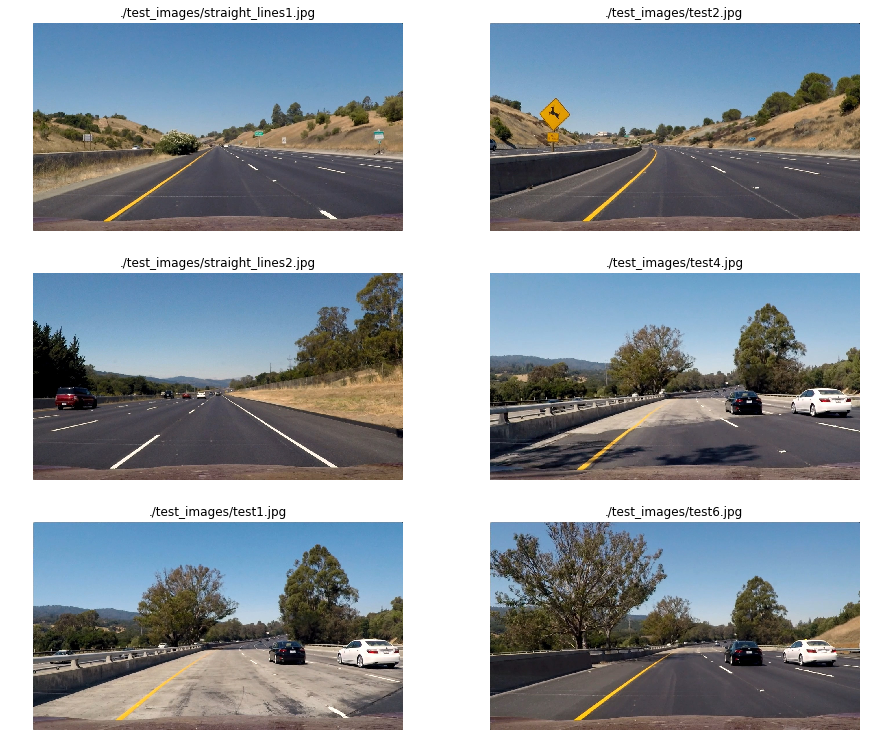

In [5]:
Images=glob_OpenImages('./test_images/*.jpg')
showImages(Images, 2, 3, (15, 13))

index=0
fname, image=Images[index]


'Done'

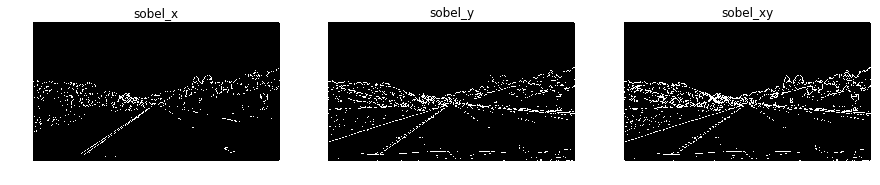

In [6]:
#Greate SOBEL FIG.

sobel_x=abs_sobel_thresh(image,'x',30,100,5)
sobel_y=abs_sobel_thresh(image,'y',30,100,5)
sobel_xy=abs_sobel_thresh(image,'xy',30,100,5)
sobels=[['sobel_x',sobel_x]]
sobels.append(('sobel_y',sobel_y))
sobels.append(('sobel_xy',sobel_xy))
showImages(sobels, 3, 1, (15, 13),'gray')

'Done'

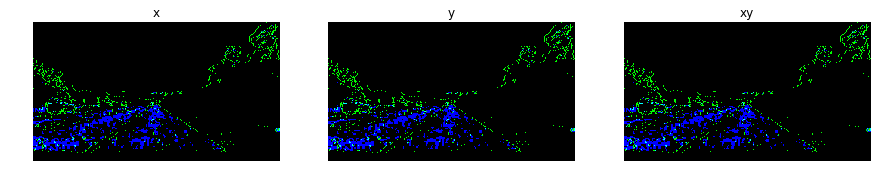

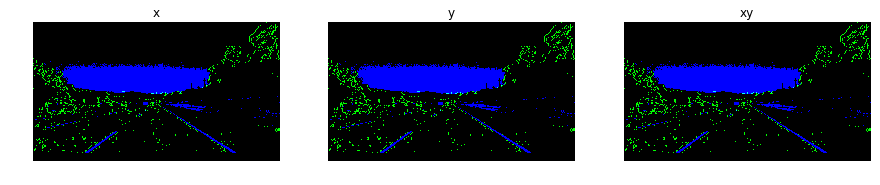

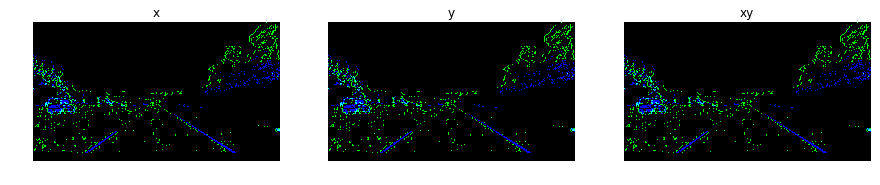

In [52]:
#Greate SOBEL combining HLS FIG.

Sobel_hls=Sobel_HLS(image,'h')
showImages(Sobel_hls, 3, 1, (15, 13),'gray')
Sobel_hls=Sobel_HLS(image,'l')
showImages(Sobel_hls, 3, 1, (15, 13),'gray')
Sobel_hls=Sobel_HLS(image,'s')
showImages(Sobel_hls, 3, 1, (15, 13),'gray')


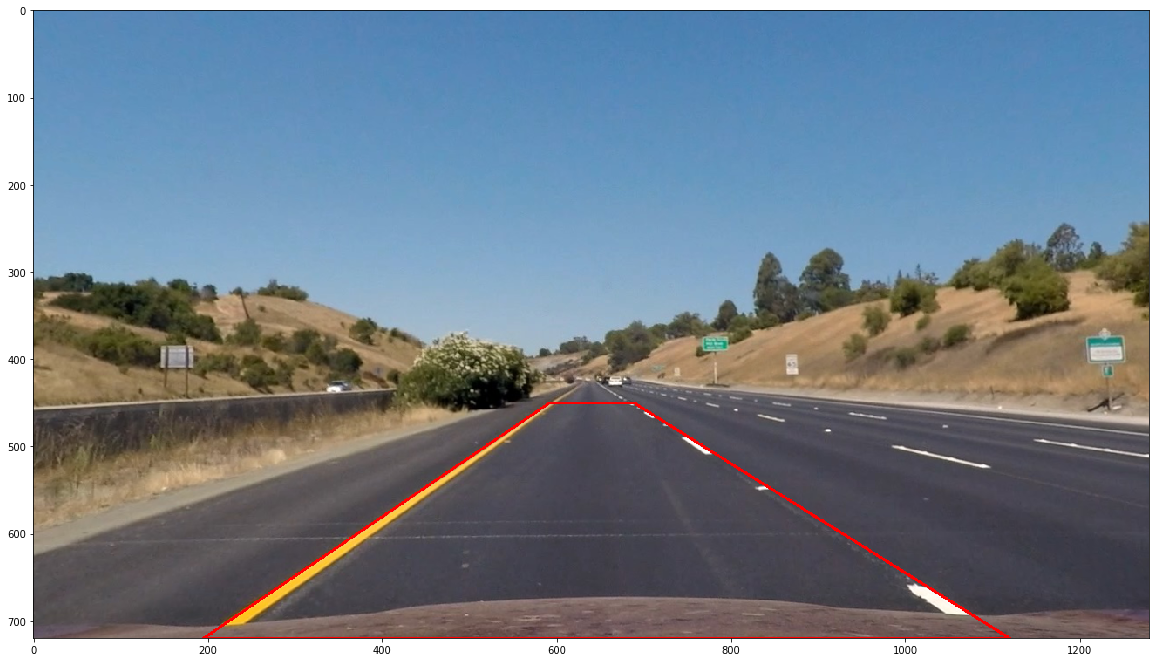

In [13]:
dist_pickle = pickle.load( open('./Pickled_data/camera_calibration.p', 'rb') )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

np_2=image.copy()
np_2=cv2.cvtColor(np_2,cv2.COLOR_BGR2RGB)

x0,y0=195,image.shape[0]
x1,y1=1120,image.shape[0]
x2,y2=689,450
x3,y3=592,450

color = [255, 0, 0]
w = 2
undist=cv2.undistort(np_2,mtx,dist,None,mtx)
copy=undist.copy()
cv2.line(copy,(x0,y0) , (x1,y1), color,thickness=2)
cv2.line(copy, (x0,y0), (x3,y3), color,thickness=2)
cv2.line(copy, (x1,y1), (x2,y2), color,thickness=2)
cv2.line(copy,  (x2,y2), (x3,y3), color,thickness=2)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(copy)



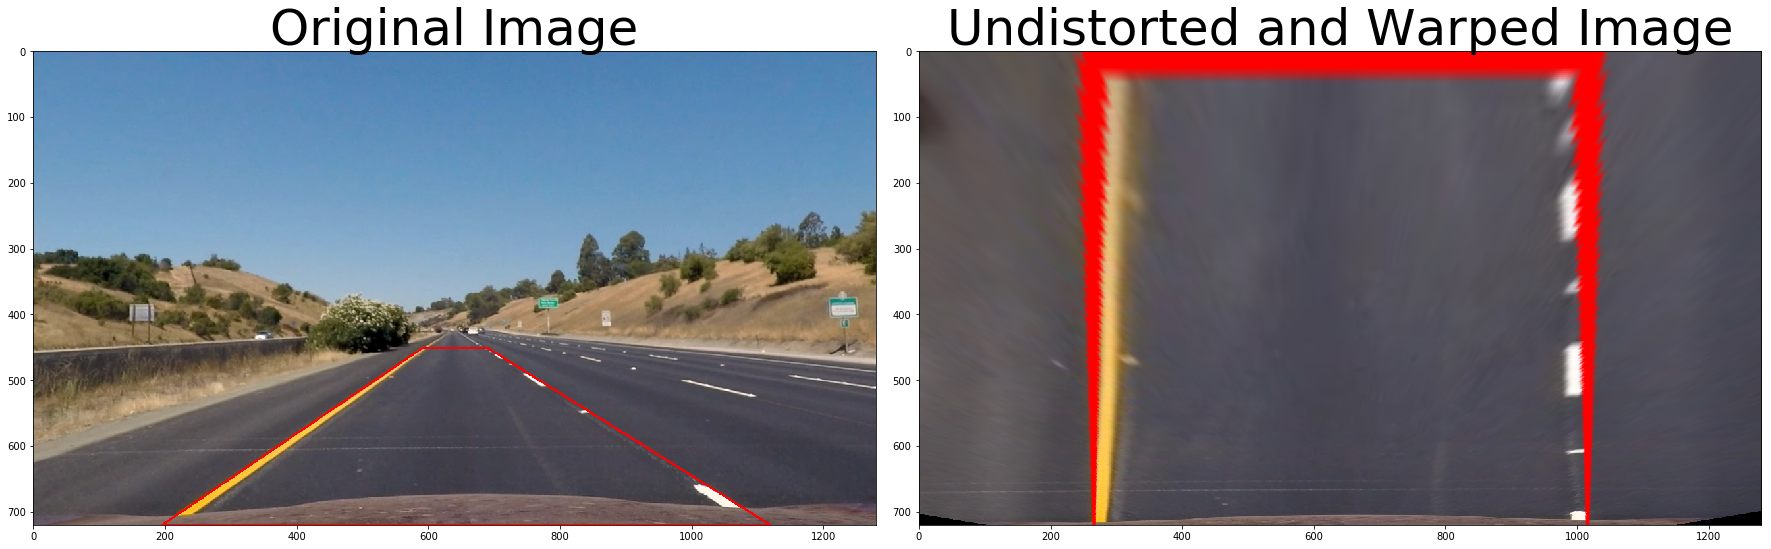

In [14]:

src=np.float32([[x0,y0],[x1,y1],[x2,y2],[x3,y3]])


image_shape=(undist.shape[1],undist.shape[0])

h=720 #height
w=750 #width
o=(copy.shape[1]-w)/2 #origin point,suppose the camera is located at center

dst=np.float32([[o,h],[w+o,h],[w+o,0],[o,0]])

M=cv2.getPerspectiveTransform(src,dst)
inv_M=cv2.getPerspectiveTransform(dst,src)

warped=cv2.warpPerspective(copy,M,image_shape,flags=cv2.INTER_LINEAR)
pickle.dump( { 'M': M,'inv_M':inv_M}, open('./Pickled_data/Perspective_M.p', 'wb'))
cp=copy.copy()
cv2.line(cp,(x0,y0) , (x1,y1), color,thickness=2)
cv2.line(cp, (x0,y0), (x3,y3), color,thickness=2)
cv2.line(cp, (x1,y1), (x2,y2), color,thickness=2)
cv2.line(cp,  (x2,y2), (x3,y3), color,thickness=2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cp)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/car_perpective.jpg')

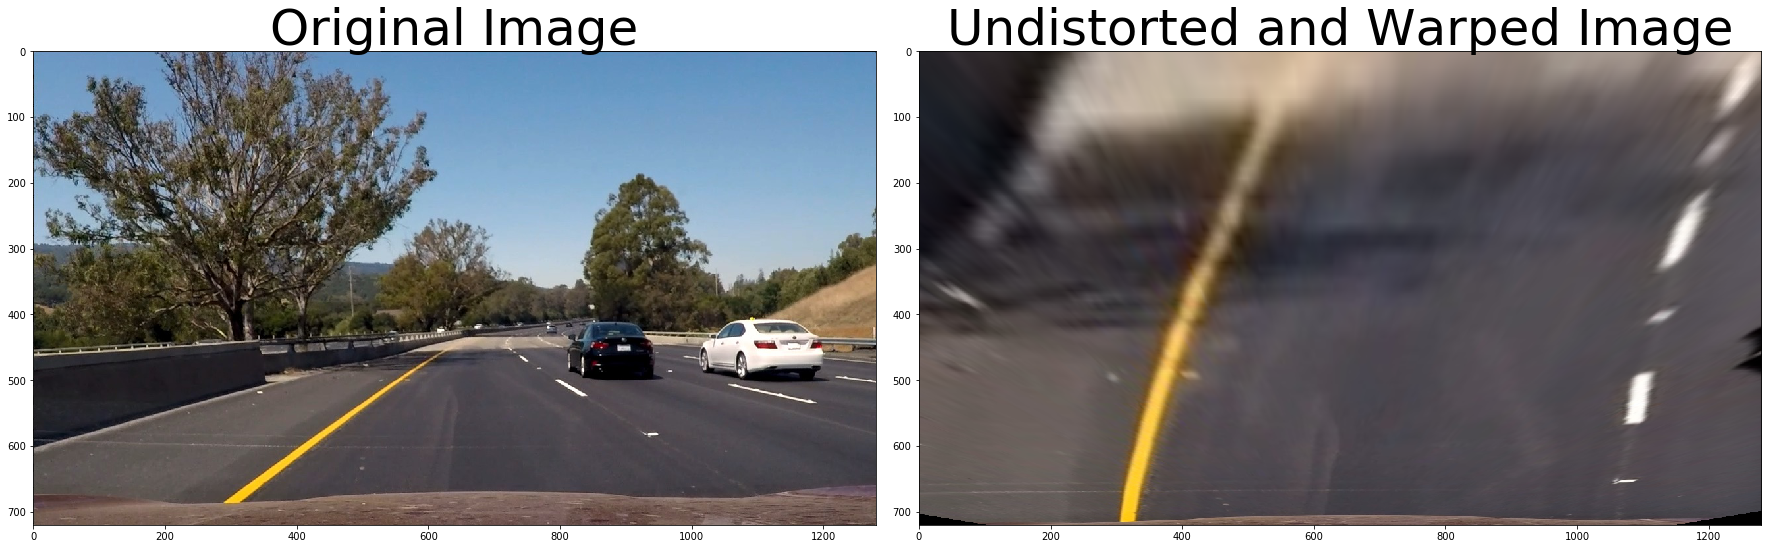

In [15]:
#test


fname, test=Images[5]
test=cv2.cvtColor(test,cv2.COLOR_BGR2RGB)
undist_test=cv2.undistort(test,mtx,dist,None,mtx)
image_shape=(undist.shape[1],undist.shape[0])
warped_test=cv2.warpPerspective(undist_test,M,image_shape,flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_test)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
